# Data preparation

## Data Description

Data is generated from white blood cells from 48 individuals. Key details:

- A single file with 48 columns of data, plus some auxiliary columns
- Auxiliary columns: Probe name, Gene Symbol, Entrez Gene Id (ignore the rest)
- A single gene (identified by a Gene Symbol or Entrez Gene Id) could have multiple probes
- Total of 41,094 probes

Data Columns:
1. 12 Male Non-smokers (106-117)
2. 12 Male Smokers (118-129)
3. 12 Female Non-Smokers (130-141)
4. 12 Female Smokers (142-153)

Important notes:
- Values are logs to the base 2 of the original value
- Some 0 values are present due to thresholding low values before taking the log


In [21]:
import pandas as pd
import numpy as np

In [22]:
# Load the data
data = pd.read_csv('Raw Data_GeneSpring.txt', sep='\t')  # Load data using tab as separator

In [23]:
# Display the first few rows and basic information about the dataset
print(data.head())
print(data.info())

         ProbeName  GSM1149106_M_Ns3.txt:gProcessedSignal(normalized)  \
0  GE_BrightCorner                                          17.288560   
1       DarkCorner                                           2.172766   
2      A_24_P66027                                          11.954556   
3      A_32_P77178                                           6.224496   
4     A_23_P212522                                           9.328137   

   GSM1149107_M_Ns4.txt:gProcessedSignal(normalized)  \
0                                          18.103434   
1                                           0.075925   
2                                          11.681619   
3                                           6.963845   
4                                           9.164498   

   GSM1149108_M_Ns5.txt:gProcessedSignal(normalized)  \
0                                          18.280110   
1                                           0.232402   
2                                          11.831579   


In [24]:
# Separate auxiliary columns and gene expression data
auxiliary_columns = ['ProbeName', 'GeneSymbol', 'EntrezGeneID', 'Go']
gene_expression_columns = [col for col in data.columns if col not in auxiliary_columns]

In [25]:
# Create separate dataframes for auxiliary information and gene expression data
auxiliary_data = data[auxiliary_columns]
gene_expression_data = data[gene_expression_columns]

In [26]:
# Convert gene expression data to numeric type, replacing any non-numeric values with NaN
gene_expression_data = gene_expression_data.apply(pd.to_numeric, errors='coerce')

In [27]:
# Display basic statistics of the gene expression data
print(gene_expression_data.describe())

       GSM1149106_M_Ns3.txt:gProcessedSignal(normalized)  \
count                                       41093.000000   
mean                                            6.128693   
std                                             4.114148   
min                                             0.000000   
25%                                             2.932579   
50%                                             6.374927   
75%                                             9.182739   
max                                            18.298971   

       GSM1149107_M_Ns4.txt:gProcessedSignal(normalized)  \
count                                       41093.000000   
mean                                            6.350905   
std                                             4.154255   
min                                             0.000000   
25%                                             3.195622   
50%                                             6.636967   
75%                                    

In [28]:
# Check for missing values
print("Missing values in gene expression data:")
print(gene_expression_data.isnull().sum().sum())

Missing values in gene expression data:
0


In [29]:
# Group data by gender and smoking status
male_non_smokers = gene_expression_data.iloc[:, 0:12]
male_smokers = gene_expression_data.iloc[:, 12:24]
female_non_smokers = gene_expression_data.iloc[:, 24:36]
female_smokers = gene_expression_data.iloc[:, 36:48]

In [30]:
# Display the shape of each group
print("Shape of each group:")
print(f"Male Non-smokers: {male_non_smokers.shape}")
print(f"Male Smokers: {male_smokers.shape}")
print(f"Female Non-smokers: {female_non_smokers.shape}")
print(f"Female Smokers: {female_smokers.shape}")

Shape of each group:
Male Non-smokers: (41093, 12)
Male Smokers: (41093, 12)
Female Non-smokers: (41093, 12)
Female Smokers: (41093, 12)


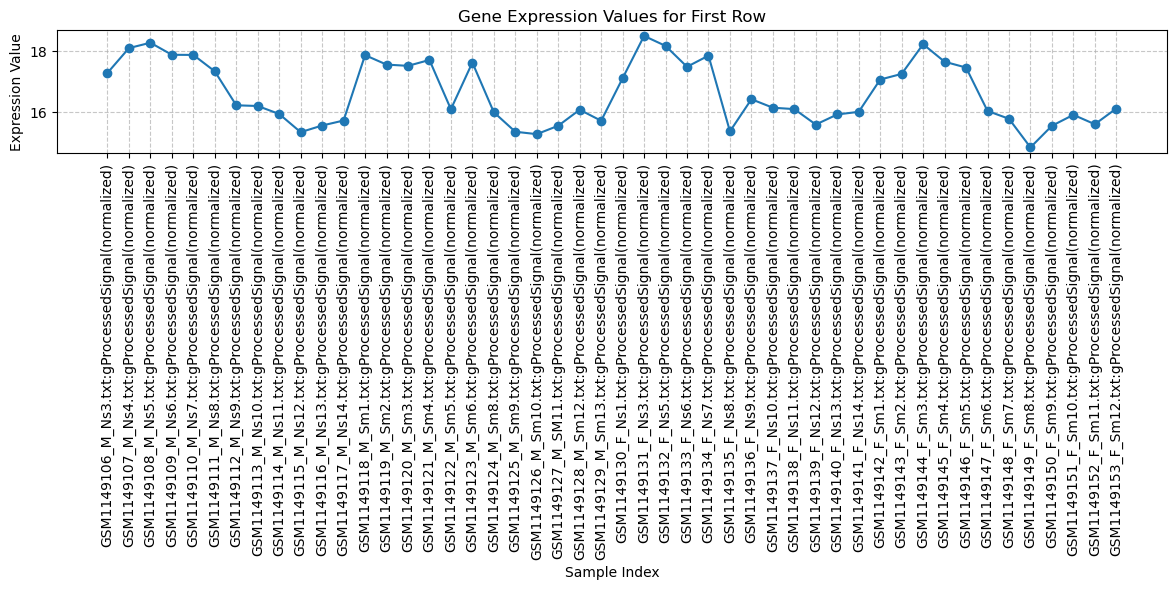

In [39]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import nbformat  # Import nbformat to check its version

# Get the first row of gene expression data
first_row = gene_expression_data.iloc[0]

# Create a line plot of the first row values
plt.figure(figsize=(12, 6))  # Set figure size
plt.plot(range(len(first_row)), first_row.values, marker='o')  # Plot values with markers

# Customize the plot
plt.title('Gene Expression Values for First Row')  # Add title
plt.xlabel('Sample Index')  # Label x-axis
plt.ylabel('Expression Value')  # Label y-axis
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines

# Rotate x-axis labels for better readability
plt.xticks(range(len(first_row)), first_row.index, rotation=90)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

In [52]:
def custom_two_way_anova(data, factor1, factor2):
    n = len(data)  # Total number of observations
    grand_mean = np.mean(data)  # Overall mean
    
    # Calculate SST (Total Sum of Squares)
    sst = np.sum((data - grand_mean)**2)  # Calculate total sum of squares
    
    # Calculate SS for Factor 1
    ss1 = sum(len(group) * (np.mean(group) - grand_mean)**2 for group in [data[factor1 == level] for level in np.unique(factor1)])  # Sum of squares for factor 1
    
    # Calculate SS for Factor 2
    ss2 = sum(len(group) * (np.mean(group) - grand_mean)**2 for group in [data[factor2 == level] for level in np.unique(factor2)])  # Sum of squares for factor 2
    
    # Calculate SS for Interaction
    ss_interaction = sum(len(group) * (np.mean(group) - grand_mean)**2 for group in [data[(factor1 == f1) & (factor2 == f2)] for f1 in np.unique(factor1) for f2 in np.unique(factor2)]) - ss1 - ss2  # Sum of squares for interaction
    
    # Calculate SSE (Error Sum of Squares)
    sse = sst - ss1 - ss2 - ss_interaction  # Error sum of squares
    
    # Degrees of freedom
    df1 = len(np.unique(factor1)) - 1  # Degrees of freedom for factor 1
    df2 = len(np.unique(factor2)) - 1  # Degrees of freedom for factor 2
    df_interaction = df1 * df2  # Degrees of freedom for interaction
    dfe = n - (len(np.unique(factor1)) * len(np.unique(factor2)))  # Degrees of freedom for error
    
    # Mean Squares
    ms1 = ss1 / df1  # Mean square for factor 1
    ms2 = ss2 / df2  # Mean square for factor 2
    ms_interaction = ss_interaction / df_interaction  # Mean square for interaction
    mse = sse / dfe  # Mean square error
    
    # F-values
    f1 = ms1 / mse  # F-value for factor 1
    f2 = ms2 / mse  # F-value for factor 2
    f_interaction = ms_interaction / mse  # F-value for interaction
    
    # P-values
    p1 = 1 - stats.f.cdf(f1, df1, dfe)  # P-value for factor 1
    p2 = 1 - stats.f.cdf(f2, df2, dfe)  # P-value for factor 2
    p_interaction = 1 - stats.f.cdf(f_interaction, df_interaction, dfe)  # P-value for interaction
    
    return (f1, p1), (f2, p2), (f_interaction, p_interaction)  # Return F-values and p-values for both factors and interaction

In [57]:
def perform_two_way_anova(row_index):
    row_data = data.iloc[row_index]  # Get the row data for the specified index
    
    # Prepare data for ANOVA
    male_non_smoker = row_data[male_non_smokers.columns].values  # Extract male non-smoker values
    male_smoker = row_data[male_smokers.columns].values  # Extract male smoker values
    female_non_smoker = row_data[female_non_smokers.columns].values  # Extract female non-smoker values
    female_smoker = row_data[female_smokers.columns].values  # Extract female smoker values
    
    # Combine all data into a single array
    all_data = np.concatenate([male_non_smoker, male_smoker, female_non_smoker, female_smoker])  # Combine all data
    
    # Create factor arrays
    gender = np.repeat(['Male', 'Female'], len(all_data) // 2)  # Create gender factor array
    smoking = np.tile(np.repeat(['Non-smoker', 'Smoker'], len(male_non_smoker)), 2)  # Create smoking factor array
    
    # Perform two-way ANOVA using custom function
    _, _, (_, p_interaction) = custom_two_way_anova(all_data, gender, smoking)  # Perform custom two-way ANOVA
    
    return p_interaction  # Return p-value for interaction (different response to smoke in men vs women)

In [61]:
# Create an array to store p-values for each row
p_values = np.zeros(data.shape[0])  # Initialize array with zeros for each row

# Iterate through each row and calculate p-value
for i in range(data.shape[0]):
    p_values[i] = perform_two_way_anova(i)  # Calculate and store p-value for each row
    print(f"Processing row {i+1}/{data.shape[0]}, p-value: {p_values[i]:.4f}")  # Print progress and p-value for each row

# Print the shape of the p_values array to confirm
print(f"Shape of p_values array: {p_values.shape}")  # Display the shape of the resulting array

Processing row 1/41093, p-value: 0.9761
Processing row 2/41093, p-value: 0.5642
Processing row 3/41093, p-value: 0.4624
Processing row 4/41093, p-value: 0.6588
Processing row 5/41093, p-value: 0.8536
Processing row 6/41093, p-value: 0.5111
Processing row 7/41093, p-value: 0.7951
Processing row 8/41093, p-value: 0.5469
Processing row 9/41093, p-value: 0.8972
Processing row 10/41093, p-value: 0.9469
Processing row 11/41093, p-value: 0.5371
Processing row 12/41093, p-value: 0.6049
Processing row 13/41093, p-value: 0.6592
Processing row 14/41093, p-value: 0.3179
Processing row 15/41093, p-value: 0.5989
Processing row 16/41093, p-value: 0.8493
Processing row 17/41093, p-value: 0.3753
Processing row 18/41093, p-value: 0.8546
Processing row 19/41093, p-value: 0.2126
Processing row 20/41093, p-value: 0.3606
Processing row 21/41093, p-value: 0.7641
Processing row 22/41093, p-value: 0.5702
Processing row 23/41093, p-value: 0.6062
Processing row 24/41093, p-value: 0.7621
Processing row 25/41093, 

C:\Users\VICTOR\AppData\Local\Temp\ipykernel_18508\590167779.py:33: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\VICTOR\AppData\Local\Temp\ipykernel_18508\590167779.py:34: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\VICTOR\AppData\Local\Temp\ipykernel_18508\590167779.py:35: RuntimeWarning:

invalid value encountered in scalar divide



Processing row 3472/41093, p-value: 0.7776
Processing row 3473/41093, p-value: 0.9767
Processing row 3474/41093, p-value: 0.9305
Processing row 3475/41093, p-value: 0.2457
Processing row 3476/41093, p-value: 0.4230
Processing row 3477/41093, p-value: 0.5023
Processing row 3478/41093, p-value: 0.9592
Processing row 3479/41093, p-value: 0.7647
Processing row 3480/41093, p-value: 0.5148
Processing row 3481/41093, p-value: 0.2824
Processing row 3482/41093, p-value: 0.4687
Processing row 3483/41093, p-value: 0.2599
Processing row 3484/41093, p-value: 0.5175
Processing row 3485/41093, p-value: 0.6390
Processing row 3486/41093, p-value: 0.5101
Processing row 3487/41093, p-value: 0.4139
Processing row 3488/41093, p-value: 0.6689
Processing row 3489/41093, p-value: 0.0604
Processing row 3490/41093, p-value: 0.5988
Processing row 3491/41093, p-value: 0.9328
Processing row 3492/41093, p-value: 0.9957
Processing row 3493/41093, p-value: 0.9534
Processing row 3494/41093, p-value: 0.6289
Processing 

Note that the row 1 in data corresponds to the entry at index 0 in the p_values array.

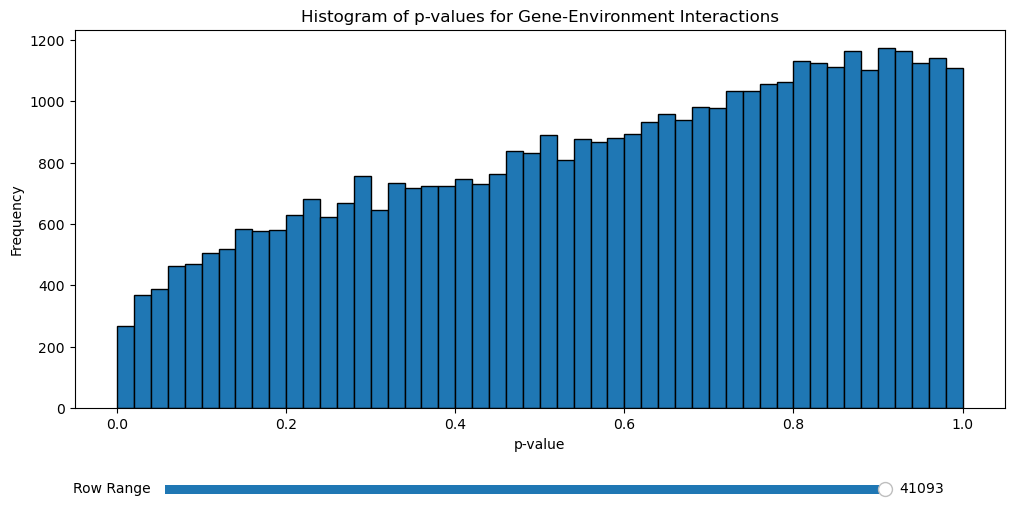

In [62]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Create the main figure and axis
fig, ax = plt.subplots(figsize=(12, 6))  # Create a figure with a larger size for better visibility
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom margin to make room for the slider

# Plot the initial histogram
n, bins, patches = ax.hist(p_values, bins=50, edgecolor='black')  # Create histogram with 50 bins and black edges

# Set labels and title
ax.set_xlabel('p-value')  # Label for x-axis
ax.set_ylabel('Frequency')  # Label for y-axis
ax.set_title('Histogram of p-values for Gene-Environment Interactions')  # Title for the plot

# Create the slider axis
slider_ax = plt.axes([0.2, 0.1, 0.6, 0.03])  # Position of the slider [left, bottom, width, height]
slider = Slider(slider_ax, 'Row Range', 1, data.shape[0], valinit=data.shape[0], valstep=1)  # Create slider object

# Function to update the plot when the slider is moved
def update(val):
    num_rows = int(slider.val)  # Get the current value of the slider
    ax.clear()  # Clear the current plot
    ax.hist(p_values[:num_rows], bins=50, edgecolor='black')  # Plot new histogram with updated data
    ax.set_xlabel('p-value')  # Reset x-axis label
    ax.set_ylabel('Frequency')  # Reset y-axis label
    ax.set_title(f'Histogram of p-values for Gene-Environment Interactions (Rows 1-{num_rows})')  # Update title with row range
    fig.canvas.draw_idle()  # Redraw the figure

# Connect the update function to the slider
slider.on_changed(update)  # Call update function when slider value changes

plt.show()  # Display the plot


Based on the histogram of p-values for gene-environment interactions, we can interpret the results as follows:
1. Distribution shape: The histogram shows a relatively uniform distribution of p-values across the range from 0 to 1, with a slight increase in frequency towards higher p-values.
   
2. Interpretation:
 - P-values close to 0 indicate strong evidence against the null hypothesis (i.e., there is likely a significant gene-environment interaction).
 - P-values close to 1 indicate weak evidence against the null hypothesis (i.e., there is likely no significant gene-environment interaction).
  
3.Findings:
There is a slight increase in frequency for higher p-values, suggesting that for many genes, there may not be strong evidence of gene-environment interactions.
However, there are still a considerable number of genes with low p-values, indicating potential significant interactions for some genes.

In [63]:
# Find rows with p-values < 0.05
significant_rows = data[p_values < 0.05]  # Filter data for rows with p-values less than 0.05

# Print the number of significant rows
print(f"Number of rows with p-values < 0.05: {len(significant_rows)}")  # Display count of significant rows

# Display the first few significant rows
print("\nFirst few significant rows:")
print(significant_rows.head())  # Show the first 5 rows of significant data

# Calculate the percentage of significant rows
percentage_significant = (len(significant_rows) / len(data)) * 100  # Calculate percentage of significant rows
print(f"\nPercentage of rows with p-values < 0.05: {percentage_significant:.2f}%")  # Display percentage with 2 decimal places

# Optional: Save significant rows to a CSV file
significant_rows.to_csv('significant_gene_environment_interactions.csv', index=False)  # Save significant rows to CSV
print("\nSignificant rows have been saved to 'significant_gene_environment_interactions.csv'")  # Confirm save operation


Number of rows with p-values < 0.05: 811

First few significant rows:
        ProbeName  GSM1149106_M_Ns3.txt:gProcessedSignal(normalized)  \
43   A_23_P111020                                           6.274315   
62   A_23_P151294                                           4.025540   
88   A_24_P926770                                           7.474671   
123  A_23_P145024                                          11.561870   
127  A_24_P910381                                           6.558103   

     GSM1149107_M_Ns4.txt:gProcessedSignal(normalized)  \
43                                            6.972955   
62                                            6.789796   
88                                            7.623500   
123                                          11.799589   
127                                           6.041059   

     GSM1149108_M_Ns5.txt:gProcessedSignal(normalized)  \
43                                            7.077835   
62                              

In [73]:
# Find the index of the minimum non-NaN p-value
min_p_value_index = np.nanargmin(p_values)  # Get the index of the lowest non-NaN p-value in the numpy array

# Get the minimum non-NaN p-value
min_p_value = np.nanmin(p_values)  # Get the minimum non-NaN p-value

# Print the row number (index + 1) and its p-value
print(f"Row number with minimum p-value: {min_p_value_index + 1}")  # Print row number (index + 1 because indexing starts at 0)
print(f"Minimum p-value: {min_p_value:.6e}")  # Print minimum p-value in scientific notation


Row number with minimum p-value: 30369
Minimum p-value: 1.105540e-04


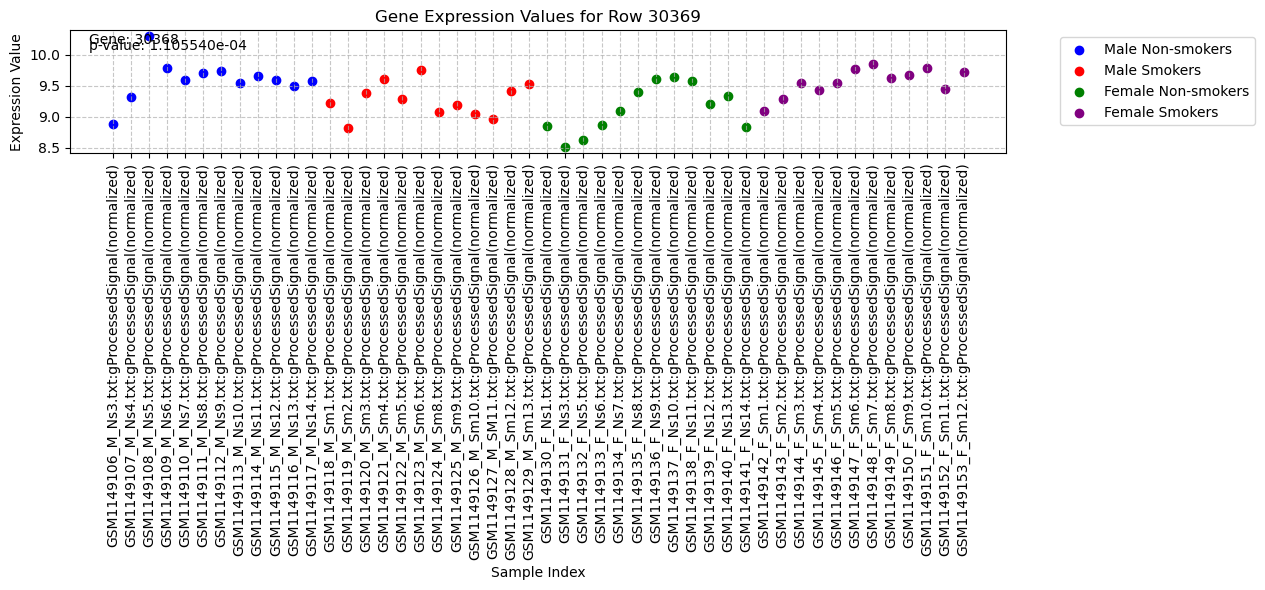

Gene: 30368
p-value: 1.105540e-04
Mean expression value: 9.3903
Standard deviation: 0.3626
Minimum expression value: 8.5030
Maximum expression value: 10.3053


In [80]:
# Get the row 30369 of gene expression data
row_30369 = gene_expression_data.iloc[30368]  # Subtract 1 because indexing starts at 0

# Create a scatter plot of the row 30369 values
plt.figure(figsize=(12, 6))  # Set figure size

# Define groups and their corresponding colors
groups = ['Male Non-smokers', 'Male Smokers', 'Female Non-smokers', 'Female Smokers']
colors = ['blue', 'red', 'green', 'purple']

# Plot each group separately
for i, (group, color) in enumerate(zip(groups, colors)):
    start = i * 12
    end = start + 12
    plt.scatter(range(start, end), row_30369.values[start:end], color=color, label=group)  # Plot values with colored markers

# Customize the plot
plt.title('Gene Expression Values for Row 30369')  # Add title
plt.xlabel('Sample Index')  # Label x-axis
plt.ylabel('Expression Value')  # Label y-axis
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines

# Move legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside and to the right

# Rotate x-axis labels for better readability
plt.xticks(range(len(row_30369)), row_30369.index, rotation=90)

# Add gene name or identifier as text annotation
gene_name = gene_expression_data.index[30368]  # Get gene name or identifier
plt.text(0.02, 0.98, f"Gene: {gene_name}", transform=plt.gca().transAxes, verticalalignment='top', fontsize=10)

# Add p-value as text annotation
p_value = p_values[30368]  # Get p-value for this gene
plt.text(0.02, 0.93, f"p-value: {p_value:.6e}", transform=plt.gca().transAxes, verticalalignment='top', fontsize=10)

# Adjust layout to prevent cutting off labels and legend
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for legend on the right

# Show the plot
plt.show()

# Print additional information about the gene
print(f"Gene: {gene_name}")
print(f"p-value: {p_value:.6e}")
print(f"Mean expression value: {row_30369.mean():.4f}")
print(f"Standard deviation: {row_30369.std():.4f}")
print(f"Minimum expression value: {row_30369.min():.4f}")
print(f"Maximum expression value: {row_30369.max():.4f}")